<a href="https://colab.research.google.com/github/jasondrebber/GEOL558/blob/main/Unsupervised_FirstPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning First Pass
## Jason Drebber
##### 1/18/2025

I am utilizing data from the National Snow and Ice Data Center which includes an inventory of over 130,000 glaciers with 39 features (a few of these are identifiers). The data describes the shape, form and type of glacier as well as including numeric measurements. Since this data includes so many different samples and many features about each I am interested in investigating the data further! What relationships exist among all of the worlds glaciers? how did different features co-vary? Are there obvious groups of glaciers that can be identified easily based on certain features of the data? I intend to apply a few of the unsupervised machine learning methods to investigate these questions and potentially answer others in the code and analysis below!

# Set-up

In [1]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import zipfile

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.metrics import silhouette_score

import warnings as wr
wr.filterwarnings("ignore")

In [2]:
# Access the API to load the data and save
!kaggle datasets download -d nsidcorg/glacier-inventory

with zipfile.ZipFile("glacier-inventory.zip", 'r') as zip_ref:
    zip_ref.extractall("glacier-inventory")

# Load the database file
wgi = pd.read_csv('/content/glacier-inventory/database.csv')

Dataset URL: https://www.kaggle.com/datasets/nsidcorg/glacier-inventory
License(s): CC0-1.0
glacier-inventory.zip: Skipping, found more recently modified local copy (use --force to force download)


# EDA and Cleansing

In [3]:
wgi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Glacier ID                   132890 non-null  object 
 1   Political Unit               132890 non-null  object 
 2   Continent                    132890 non-null  object 
 3   Basin Code                   132890 non-null  object 
 4   Location Code                132890 non-null  object 
 5   Glacier Code                 132890 non-null  object 
 6   Glacier Name                 46751 non-null   object 
 7   Latitude                     132890 non-null  float64
 8   Longitude                    132890 non-null  float64
 9   Primary Class                131406 non-null  float64
 10  Glacier Source               132746 non-null  float64
 11  Basin Count                  15558 non-null   float64
 12  Glacier Form                 131813 non-null  float64
 13 

The data here has 39 features but many of them are likely not useful for learning about glaciers (for example the Photograph year) or are indivually defined data that is not consistent across the whole dataset (such as the Location Code and Glacier Code which are defined in the metatdata), or columns which onl store information about certain types of glaciers (Glacier activity and activity stary and end). I will remove some of these columns manually to select only the columns which are likely to have useful information for learning (this is supported by a review of the metatdata for this dataset availabel at https://nsidc.org/sites/default/files/g01130-v001-userguide_1_0.pdf)

In [4]:
# Define which features to keep in the final data
wgi = wgi[['Glacier ID', 'Political Unit', 'Continent', 'Glacier Name', 'Latitude', 'Longitude', 'Primary Class', 'Glacier Form', 'Minimum Elevation', 'Mean Elevation', 'Maximum Elevation', 'Snow Line Elevation', 'Glacier Area', 'Mean Length', 'Mean Width', 'Maximum Length', 'Mean Depth', 'Accumulation Orientation', 'Ablation Orientation']]

# Check out the glacier information again now that I have removed some of the columns
wgi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Glacier ID                132890 non-null  object 
 1   Political Unit            132890 non-null  object 
 2   Continent                 132890 non-null  object 
 3   Glacier Name              46751 non-null   object 
 4   Latitude                  132890 non-null  float64
 5   Longitude                 132890 non-null  float64
 6   Primary Class             131406 non-null  float64
 7   Glacier Form              131813 non-null  float64
 8   Minimum Elevation         117162 non-null  float64
 9   Mean Elevation            81599 non-null   float64
 10  Maximum Elevation         115468 non-null  float64
 11  Snow Line Elevation       28848 non-null   float64
 12  Glacier Area              128374 non-null  float64
 13  Mean Length               55258 non-null   f

In [5]:
wgi['Primary Class'].value_counts()

,count
Primary Class,
6.0,65042
7.0,35201
5.0,14002
0.0,8209
3.0,2752
9.0,2711
4.0,2532
2.0,682
1.0,267


In [6]:
# Remove any row with no data
glaciers = wgi.dropna()
glaciers.shape

(789, 19)

I performed the above data cleansing step because we don't want NaN values in the dataset when we are doing ML, so it was necessary to deal with those values. Given the size of the dataset I did not want to manually deal with this for each column, so this was a simple method to get rid of a large number of potentially not-useful data. I think from a geological perspective this is appropriate because there are are large number of very small niche glaciers and glaciaretes in the world (included as Primary class 6 and 7) which have unique characteristics compared to the larger Valley glaciers and ice-fields people are familiar with (Primary Class 5 and 2). I suspect that many of the features that were removed were these smaller features which I believe would be intersting to look at, but given their large number would overwhelm the data. I intended to look at the larger glaciers in this analysis anyways. Let's do .value_counts() again to see how many of each class remain now that we removed NaNs

Primary Class
5.0    374
6.0    325
4.0     33
7.0     29
0.0     23
9.0      4
3.0      1
Name: count, dtype: int64


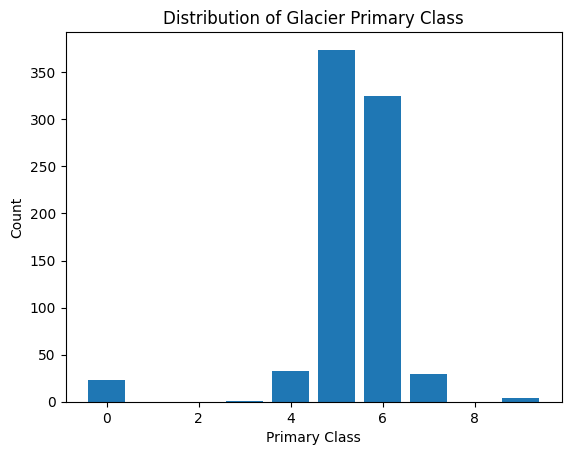

In [7]:
print(glaciers['Primary Class'].value_counts())
primary_class_counts = glaciers['Primary Class'].value_counts()
plt.bar(primary_class_counts.index, primary_class_counts.values)
plt.xlabel('Primary Class')
plt.ylabel('Count')
plt.title('Distribution of Glacier Primary Class')
plt.show()

This better reflects the distribution of glaciers that I want to analyze, so even though I may have removed some interesting features from the data by dropping all samples with a NaN value, this will turn out better.

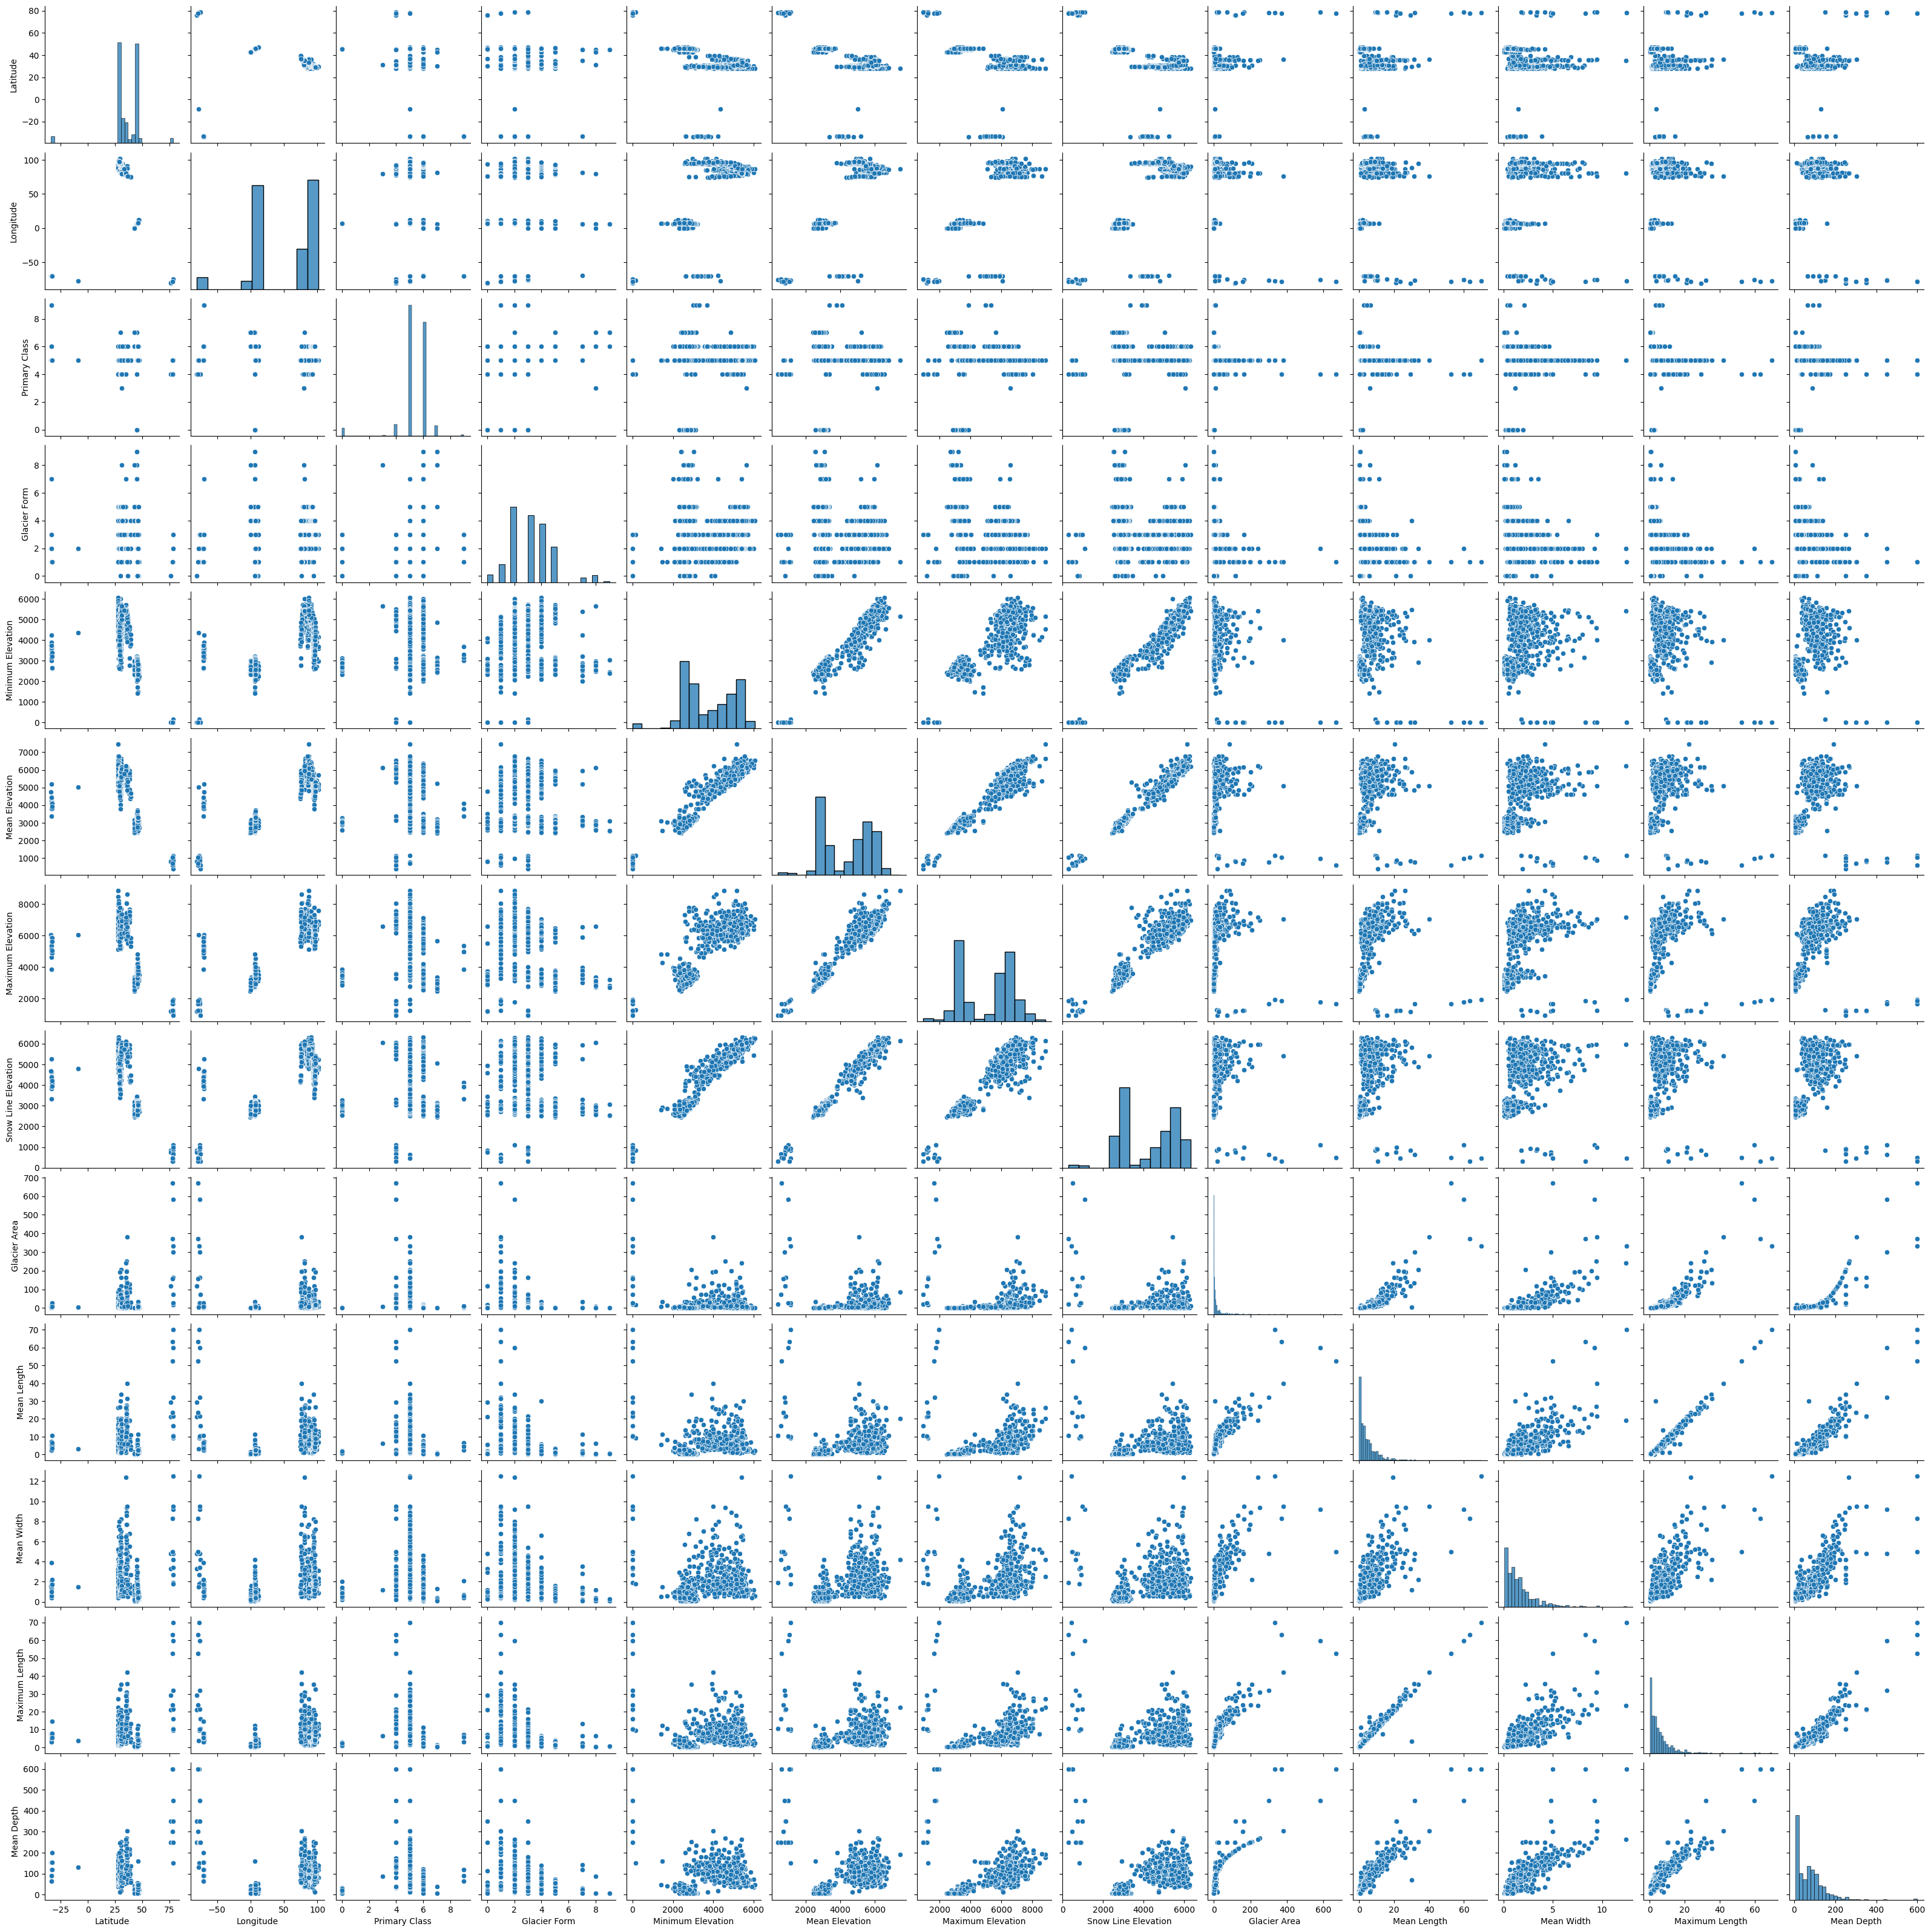

In [8]:
sns.pairplot(glaciers)

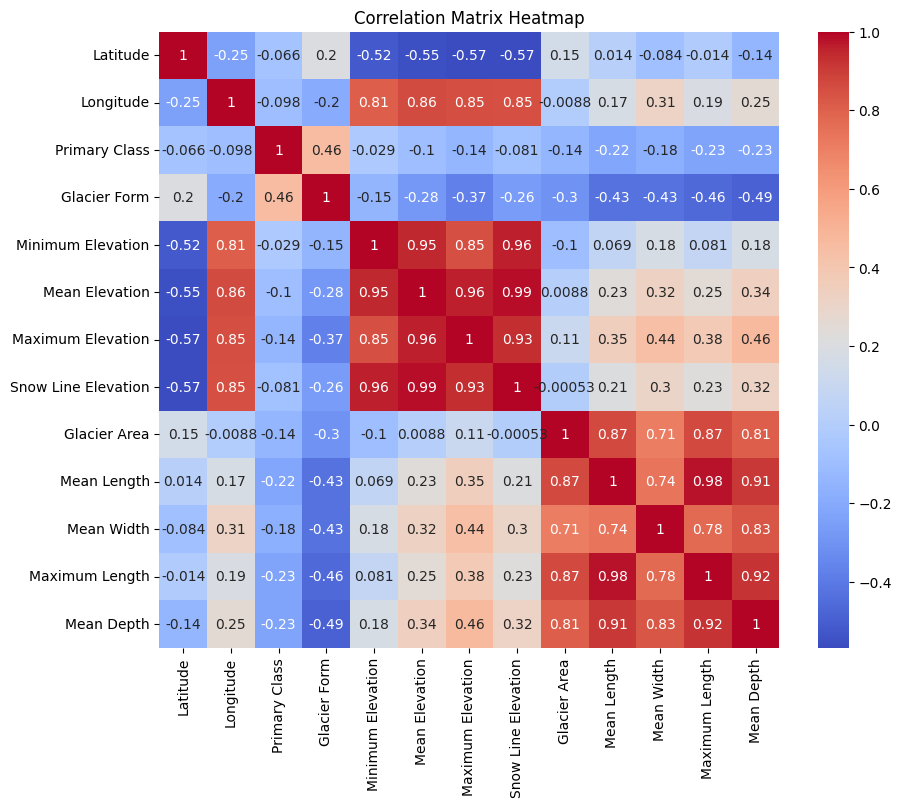

In [9]:
# Calculate the correlation matrix, but only for numeric columns
corr_matrix = glaciers.select_dtypes(include=np.number).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

There are many interesting relationships indicated in the figures above. Ohe thing is the correlation between Glacier Latitude and Elevation paramters (Mean, Min, Max and Snow Line) I suspect this is because as glaciers increase in latitude, they do not have to be as high to achieve a sustainable mass balance throughout the year. Another that makes sense is the relationship between glacier area and features like length, width which both accoutn for area. I am not sure why Longitude is so positively correlated to the elevaton parameters, although I do not take much stock in this due to the arbitrary nature of longitude values.

# Data Pre-Processing

The first step here will be to scale all of the numeric columns to a uniform distribution using the quantile scaler. This will place everything on the same scale and hopefully help to make the machine learning algorithms run better. I excluded categorical columns such as Glacier ID, Political Unit, and Name which should remain unchanged here as well as excluded Latitude and Longitude even though they are numeric.

In [10]:
# Columns that should not be transformed
excluded_columns = [
    "Glacier ID", "Political Unit", "Continent", "Glacier Name",
    "Latitude", "Longitude", "Primary Class", "Glacier Form",
    "Accumulation Orientation", "Ablation Orientation"
]

# Select numeric columns that are not excluded
numeric_columns = glaciers.select_dtypes(include=["float64", "int64"]).columns
columns_to_transform = [col for col in numeric_columns if col not in excluded_columns]

# Apply QuantileTransformer
qt = QuantileTransformer(output_distribution='uniform', random_state=42)

# Create a copy of the glaciers DataFrame to store scaled values
scaled_glaciers = glaciers.copy() # Create scaled_glaciers here

scaled_glaciers[columns_to_transform] = qt.fit_transform(glaciers[columns_to_transform])

scaled_glaciers.head()

,Glacier ID,Political Unit,Continent,Glacier Name,Latitude,Longitude,Primary Class,Glacier Form,Minimum Elevation,Mean Elevation,Maximum Elevation,Snow Line Elevation,Glacier Area,Mean Length,Mean Width,Maximum Length,Mean Depth,Accumulation Orientation,Ablation Orientation
7836,BT5O240A0006,BHUTAN,ASIA,ZHENXIELI,28.241,90.296,6.0,3.0,0.989848,0.964467,0.876269,0.987310,0.437817,0.552030,0.502538,0.547589,0.482868,NW,NW
22743,CA2S011H0020,CANADA,NORTH AMERICA,WILCOX GLACIER,76.175,-80.755,4.0,0.0,0.000000,0.007614,0.003807,0.011421,0.968274,0.988579,0.876269,0.984772,0.982234,S,S
22768,CA2S011H0250,CANADA,NORTH AMERICA,CORY GLACIER,76.260,-79.960,4.0,0.0,0.000000,0.006345,0.005076,0.008883,0.970812,0.969543,0.945431,0.967005,0.993655,S,S
22949,CA2S017H0020,CANADA,NORTH AMERICA,LEFFERT GLACIER,78.697,-75.655,4.0,2.0,0.000000,0.010152,0.013959,0.016497,0.998731,0.997462,0.993655,0.997462,0.996193,E,E
22973,CA2S017I0040,CANADA,NORTH AMERICA,WYVILLE THOMSON,78.393,-75.297,4.0,3.0,0.000000,0.000000,0.000000,0.001269,0.823604,0.876904,0.704949,0.848985,0.982234,NE,NE


Next I am going to drop a few columns but save them to another matrix, because they will not be useful for the machine learning, but they may come in handy later.

In [11]:
# Store the ID features of the glaciers
glacier_ids = scaled_glaciers[['Glacier ID', 'Political Unit', 'Continent', 'Glacier Name']]
glacier_long = scaled_glaciers[['Longitude']]
glacier_lat = scaled_glaciers[['Latitude']]

# Drop the features that are saved above
scaled_glaciers = scaled_glaciers.drop(columns=['Glacier ID', 'Political Unit', 'Continent', 'Glacier Name', 'Longitude', 'Latitude'])
scaled_glaciers.head()

,Primary Class,Glacier Form,Minimum Elevation,Mean Elevation,Maximum Elevation,Snow Line Elevation,Glacier Area,Mean Length,Mean Width,Maximum Length,Mean Depth,Accumulation Orientation,Ablation Orientation
7836,6.0,3.0,0.989848,0.964467,0.876269,0.987310,0.437817,0.552030,0.502538,0.547589,0.482868,NW,NW
22743,4.0,0.0,0.000000,0.007614,0.003807,0.011421,0.968274,0.988579,0.876269,0.984772,0.982234,S,S
22768,4.0,0.0,0.000000,0.006345,0.005076,0.008883,0.970812,0.969543,0.945431,0.967005,0.993655,S,S
22949,4.0,2.0,0.000000,0.010152,0.013959,0.016497,0.998731,0.997462,0.993655,0.997462,0.996193,E,E
22973,4.0,3.0,0.000000,0.000000,0.000000,0.001269,0.823604,0.876904,0.704949,0.848985,0.982234,NE,NE


The next step in pre-processing that I am going to do is One-Hot encoding for the categorical variables in order to maximize their structure for machine learning. I will One-Hot encode, Primary Class, Glacier Form, accumulation orientation and Ablation orientation. This will ensure that they are in a form that will be approriate for the Machine learning algorithms to read effectively.

In [12]:
# Define mappings for the categorical columns
primary_class_mapping = {
    0: "Miscellaneous",
    1: "Continental Ice Sheet",
    2: "Ice Field",
    3: "Ice Cap",
    4: "Outlet Glacier",
    5: "Valley Glacier",
    6: "Mountain Glacier",
    7: "Glacieret and Snowfield",
    8: "Ice Shelf",
    9: "Rock Glacier"
}

glacier_form_mapping = {
    0: "Miscellaneous",
    1: "Compound Basins",
    2: "Compound Basin",
    3: "Simple Basin",
    4: "Cirque",
    5: "Niche",
    6: "Crater",
    7: "Ice Apron",
    8: "Group",
    9: "Remnant"
}

# Map "Primary Class" and "Glacier Form"
scaled_glaciers['Primary Class'] = scaled_glaciers['Primary Class'].map(primary_class_mapping)
scaled_glaciers['Glacier Form'] = scaled_glaciers['Glacier Form'].map(glacier_form_mapping)

# Columns to encode
columns_to_encode = ['Primary Class', 'Glacier Form', 'Accumulation Orientation', 'Ablation Orientation']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the selected columns
encoded_features = encoder.fit_transform(scaled_glaciers[columns_to_encode])

# Create a DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=scaled_glaciers.index)

# Combine the encoded columns with the rest of the DataFrame
scaled_glaciers_encoded = pd.concat([scaled_glaciers.drop(columns=columns_to_encode), encoded_df], axis=1)

# Display the first few rows of the updated DataFrame
scaled_glaciers_encoded.head()


,Minimum Elevation,Mean Elevation,Maximum Elevation,Snow Line Elevation,Glacier Area,Mean Length,Mean Width,Maximum Length,Mean Depth,Primary Class_Glacieret and Snowfield,...,Accumulation Orientation_SW,Accumulation Orientation_W,Ablation Orientation_E,Ablation Orientation_N,Ablation Orientation_NE,Ablation Orientation_NW,Ablation Orientation_S,Ablation Orientation_SE,Ablation Orientation_SW,Ablation Orientation_W
7836,0.989848,0.964467,0.876269,0.987310,0.437817,0.552030,0.502538,0.547589,0.482868,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22743,0.000000,0.007614,0.003807,0.011421,0.968274,0.988579,0.876269,0.984772,0.982234,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22768,0.000000,0.006345,0.005076,0.008883,0.970812,0.969543,0.945431,0.967005,0.993655,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22949,0.000000,0.010152,0.013959,0.016497,0.998731,0.997462,0.993655,0.997462,0.996193,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22973,0.000000,0.000000,0.000000,0.001269,0.823604,0.876904,0.704949,0.848985,0.982234,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Ok now the dataset is ready to process!

# KMeans

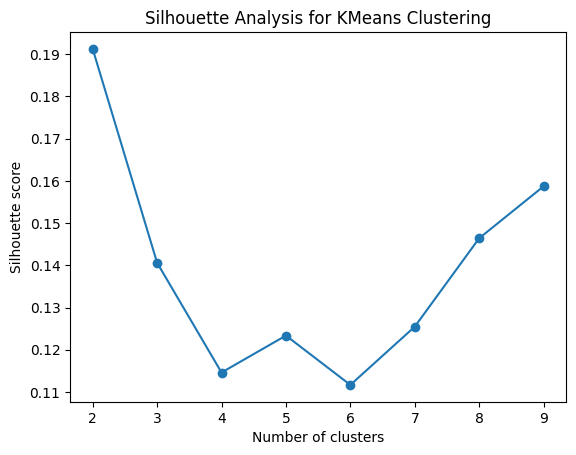

In [13]:
# Prompt: Do kmeans clustering on the scaled_glaciers_encoded variable using the scikitlearn package

# Determine the optimal number of clusters using the silhouette score
kmeans_percentiles = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_glaciers_encoded)
    kmeans_percentiles.append(silhouette_score(scaled_glaciers_encoded, kmeans.labels_))

# Plot the silhouette scores for different numbers of clusters
plt.plot(range(2, 10), kmeans_percentiles, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis for KMeans Clustering')
plt.show()

# Apply KMeans clustering with optimal number of clusters
optimal_k = np.argmax(kmeans_percentiles) + 2 # Add 2 to adjust for the range in the loop
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_glaciers_encoded)
scaled_glaciers_encoded['kmeans_cluster'] = kmeans.labels_

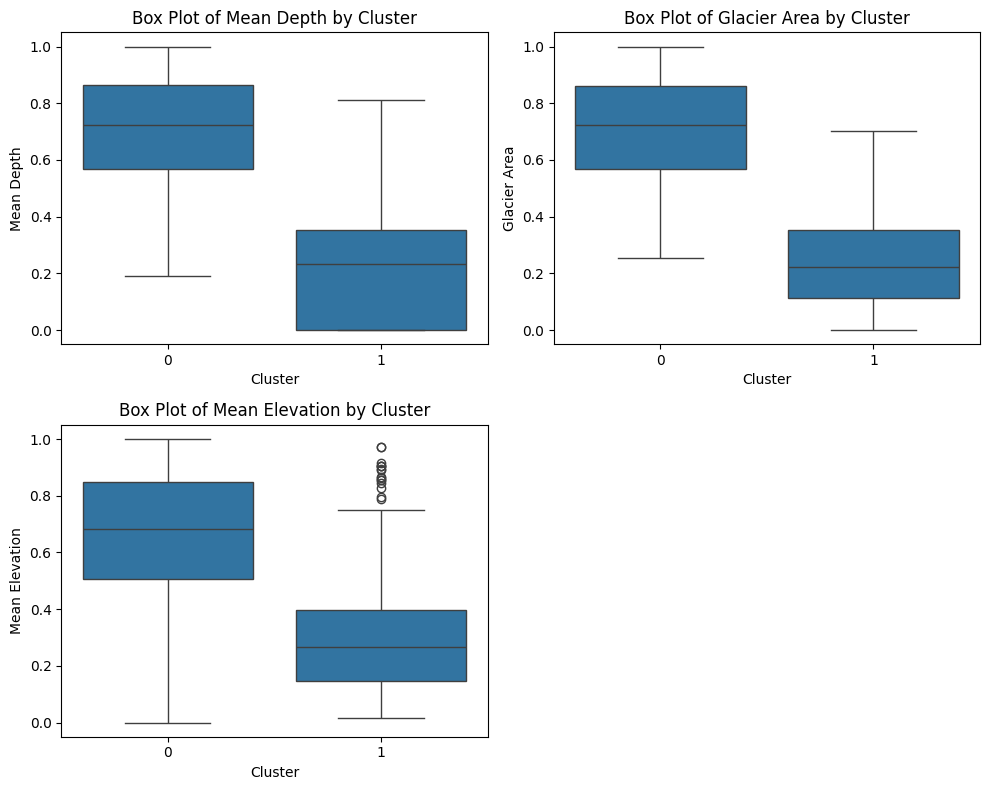

In [14]:
# Prompt: give me a box plot of the clusters for the depth, area, mean elevation and latitude on the same figure so I can compare them easily

# Create the box plot
plt.figure(figsize=(10, 8))
features_to_plot = ['Mean Depth', 'Glacier Area','Mean Elevation']
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='kmeans_cluster', y=feature, data=scaled_glaciers_encoded)
    plt.title(f'Box Plot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

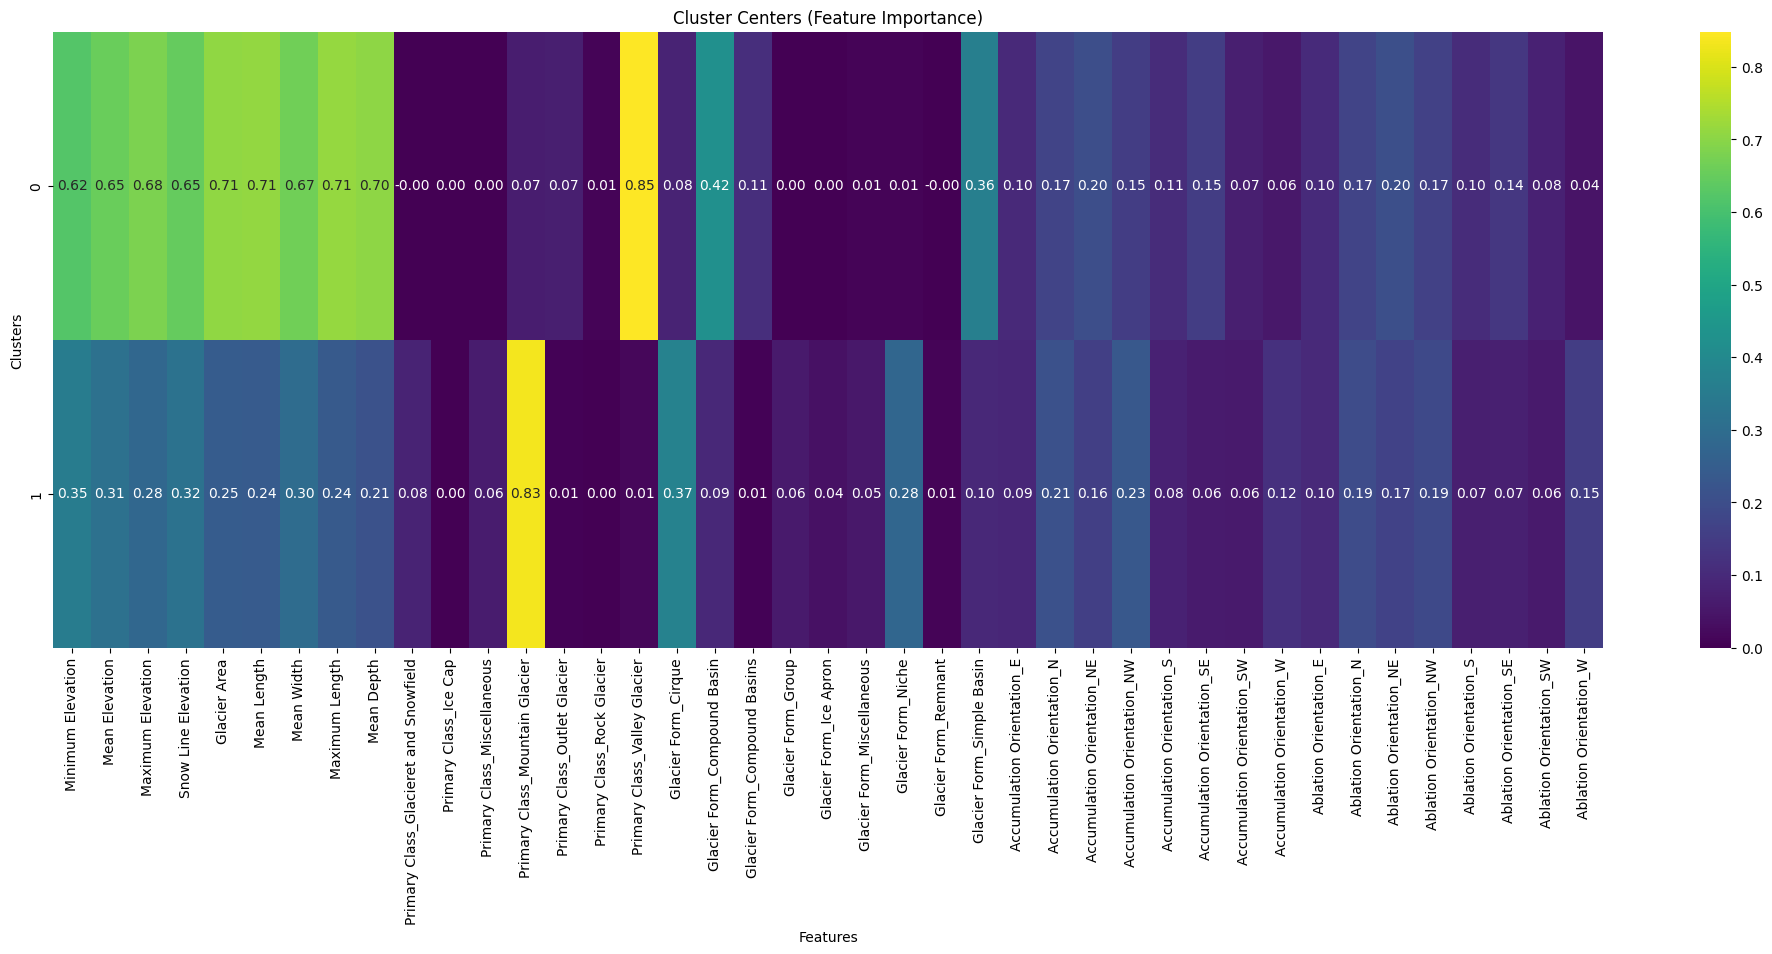

In [15]:
# Ensure the input data to KMeans matches the feature set
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=scaled_glaciers_encoded.columns[:kmeans.cluster_centers_.shape[1]]  # Match the shape
)

# Plot the cluster centers as a heatmap
plt.figure(figsize=(25, 8))
sns.heatmap(cluster_centers, cmap='viridis', annot=True, fmt=".2f")
plt.title("Cluster Centers (Feature Importance)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

This is interesting, it appears that there are most likely only two clusters according to the silhouette analysis that I performed at the beginning of the analysis. I performed Kmeans and looked at the variability of the two clusters to see how a few of the features I find to be more important vary, I found that Depth Area and Elevation were larger for cluster 0 which was more likely to be predicted by Valley glaciers which tend to be larger glacial features. Cluster 1 had lower elevation glaciers, lower area and lower mean depth and had a high feature importance from Mountain glaciers which are notably smaller than Valley Glaciers. Overall this is interesting because it shows that there is indeed a distinct difference for these two features. What surprised me the most is that the average elevation for Valley glaciers was much higher, I actually expected this to be the opposite because of the name of the two main features, however I was wrong on that account! In terms of scoring the silhouette score was 0.23 for the 2 clusters which was the highest of all from 2-10 clusters. So this is not very good overall, but it is statistically the best number of clsuters for this data.

# DBSCAN

In [16]:
scaled_glaciers_encoded.drop(columns=['kmeans_cluster'], inplace=True) # Remove the kmeans cluster column

Silhouette Score: 0.40491490233908084
Number of clusters: 44


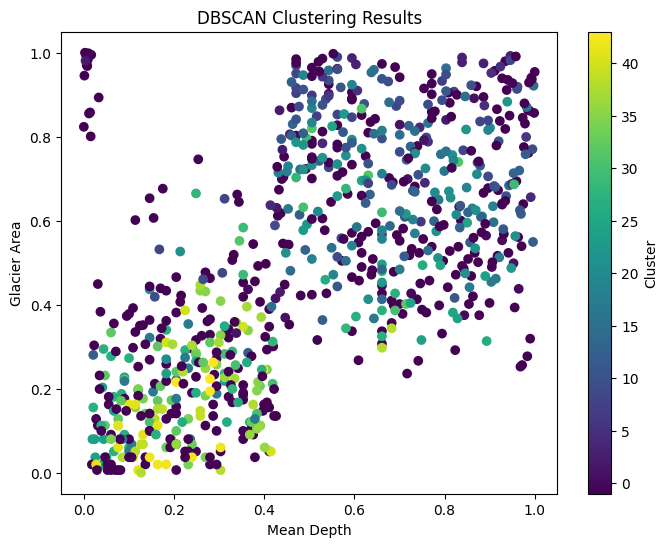

In [17]:
# Prompt: Do DBSCAN clustering on scaled_glaciers_encoded and scale it using silhoutte scoring

# Find optimal epsilon using silhouette score
dbscan_percentiles = []
for eps in np.linspace(0.1, 1, 10):
    dbscan = DBSCAN(eps=eps, min_samples=5) # Adjust min_samples as needed
    dbscan.fit(scaled_glaciers_encoded)
    if len(set(dbscan.labels_)) > 1:  # Check for more than one cluster
        dbscan_percentiles.append(silhouette_score(scaled_glaciers_encoded, dbscan.labels_))
    else:
        dbscan_percentiles.append(-1)  # Append -1 if only one cluster

optimal_eps = np.linspace(0.1, 1, 10)[np.argmax(dbscan_percentiles)]

# Apply DBSCAN with optimal epsilon
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(scaled_glaciers_encoded)

# Add cluster labels to DataFrame
scaled_glaciers_encoded['dbscan_cluster'] = dbscan.labels_

# Print the Silhouette Score
print("Silhouette Score:", silhouette_score(scaled_glaciers_encoded, dbscan.labels_))

# Print the number of clusters
print("Number of clusters:", len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))

# Visualize the clusters (example with Mean Depth and Glacier Area)
plt.figure(figsize=(8, 6))
plt.scatter(scaled_glaciers_encoded['Mean Elevation'], scaled_glaciers_encoded['Glacier Area'], c=scaled_glaciers_encoded['dbscan_cluster'], cmap='viridis')
plt.xlabel('Mean Depth')
plt.ylabel('Glacier Area')
plt.title('DBSCAN Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

The DBSCAN suggests that there are 44 clusters and gives a higher silhouette score than the kmeans clustering did. I find this intersting because that is a lot of clusters. I understand that they can be overlapping though, so it partially makes sense in this case. Overall I find this hard to visualize the results of given that there are so many dimensions to look at, it is not super intuitive and having a large number of clusters is also not particulalry helpful for recognizing patterns in the data.

# PCA

In [18]:
scaled_glaciers_encoded.drop(columns=['dbscan_cluster'], inplace=True) # Remove the dbscan cluster column

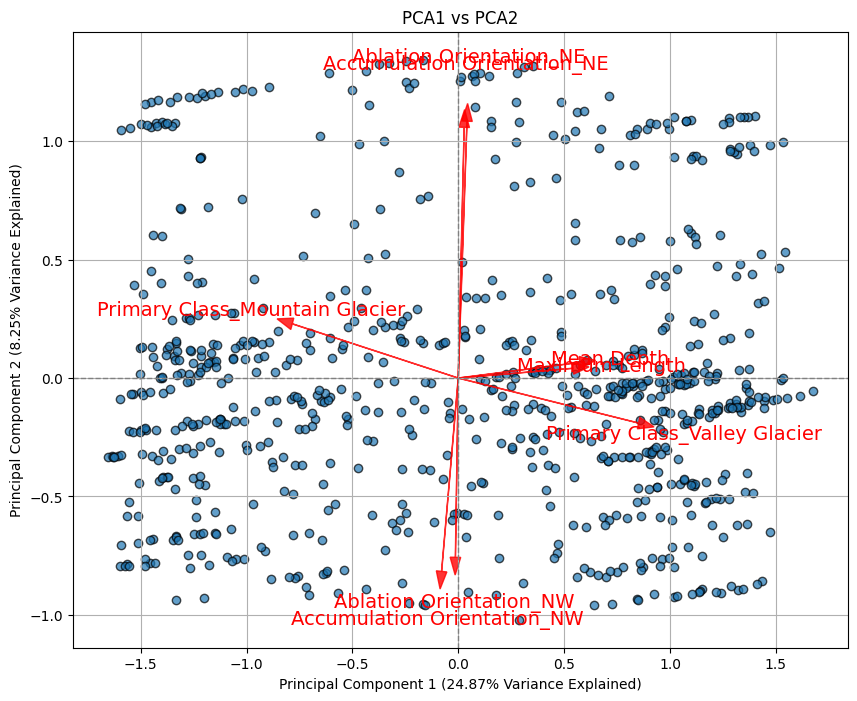

In [19]:
# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(scaled_glaciers_encoded)

# Extract explained variance and eigenvectors (loadings)
explained_variance = pca.explained_variance_ratio_
eigenvectors = pca.components_

# Scatter plot of PCA1 vs PCA2
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance Explained)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance Explained)")
plt.title("PCA1 vs PCA2")

# Calculate eigenvector magnitudes
eigenvector_magnitudes = np.sqrt(eigenvectors[0, :]**2 + eigenvectors[1, :]**2)

# Sort features by their contributions
sorted_indices = np.argsort(eigenvector_magnitudes)[::-1]
top_features = sorted_indices[:8]  # Select top 8 features

# Overlay only the top eigenvectors
for i in top_features:
    plt.arrow(0, 0, eigenvectors[0, i] * 2, eigenvectors[1, i] * 2, color='r', alpha=0.8, head_width=0.05)
    plt.text(eigenvectors[0, i] * 2.5, eigenvectors[1, i] * 2.5, scaled_glaciers_encoded.columns[i],
             color='r', fontsize=14, ha='center', va='center')


# Add grid for better visualization
plt.grid()
plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')

plt.show()



This is really interesting because what this is showing is that the principal component that accounts for most of the variability in the data is the class of glacier and that is related to the area, and depth. I wasn't able to show every eigenvector because there were so many it was hard to see (lots of overlap) so I only included the top 8 that account for variance. This was expected because this is similar to what I learned in the Kmeans clustering above, and aligns well with my domain knowledge of glaciers. A valley glacier is a larger type of glacier than a Mountain glacier and it is shown that the variance aligns for these features. What I did not expect is that the principal component which accounts for the second more variability in the features was the orientation of the glacier. In the positive direction is Northeast facing, and the negative direcition are Northwest facing glaciers. I am not entirely sure why these two directions oppose each other specifically because it is expected that northern facing slopes are more likely to have glaciers (in the northern hemisphere) because they remain more shaded than a southern facing slope which will recieve more sun in the winter and have a lower mass balance. The differnce between Northeast and Northwest facing glaciers is small and to me does not play a huge role in altering the mass balance, so I am unsure why this difference accounts for the second most variance in the data. This will take some more consideration on my part. In terms of scoring, the first principal component accounts for 24.9% of the variance in the data and the second accounts for 8.25% of the variance which means that 67% of the variance is unexplained by these two components.

# Questions

##### Which Method did you like most?

I liked the PCA the most for this specific dataset. The problem I had with the clustering is that it is difficult to display them when there are so many different features, the high-dimensional data is not siple to work with. I liked the PCA because it converted the data down into only two dimensions which is easy for my brain to process and was a lot easier to deal with in my opinion. I think that this is dataset dependent though, because I can see that for a dataset that is low-dimensional and contains only 2-3 dimensions I may like the Kmeans clustering the best since it is easy to visualize the cluster centers on a plot that large. One thing I considered is doing clustering on the PCA output because it would be easy to visualize the cluster centers on this since it has been reduced to two dimensions.

##### Which method did you like the least?

I overall did not like the DBSCAN. I find the fact that there are so many clusters confusing and even more difficult to understand and visualize than the Kmeans clustering. Also becasue the clusters overlap, I could not begin to understand how to interpret the data.

##### How did you score these unsupervised models?

I scored the clustering algorithyms using the silhouette scoring method. This was extremely simple to do particulalrly when applying the Google Colab AI tool to help with code writing. I also found this method easy to interpret, a higher value is better and a value close to o means that the clusters overlap significantly. I think that based on my results, it appears thatthe DBSCAN should have been a better clustering analysis because it had a higher silhouette score, but because it had so many clusters (essentially one for every feature) it was difficult to interpret what this result meant.

For the PCA I analyzed the explained variance of the principal components to determine how well the first two principal components were able to explain the variability of the data. They only accont for about 33% of the variability or 1/3 which tells me that there may be other components which are important beyond the first two.

##### Did the output align with your geologic understanding?

Yes the output was directly aligned with my understanding of glaciers. I was happy to see that the clustering identified the key structural and spatial differences between mountain and valley galciers. I also learned a few things that may indicate some other trends related to these key differences like elevation relationship, area relationship and a possible trend related to the orientation of the glaciers.

##### What did you wnat to learn more about?

I think that I really liked the PCA method, and this is something I would like to improve my skills with. I have learned this three times before in the past, and each time it has made slightly more sense (I remember the first time I learned it I was completely lost and had absolutely no clue what I was learning about). But at this point I am starting to get an understanding of when to use PCA, how it can benefit my research (related to when this is even useful) and how I can interpret the results. I think that I will keep learning about this method moving forward as I have also seen that it is extremely common in a lot of the literature. Another method which I did not explore here but I'd like to learn more about is the Gaussian Mixture modelling, because this seems interesting!

##### Did you pre-process your data?

Yes, I did a lot of pre-processing to get the data into a specific structure which I thought would help the machine learning models run better. I would have to run these again without some of this pre-processing to compare, but I will mention one thing, before I settled on the data that I ran here, I did not remove the latitude from the dataset, but I also did not scale it because I did not think I needed to and it felt weird to scale such a value. The results I got from that initial test were very different from what I am presenting here. I got 4 clusters, but the latitude was the only factor that mattered for the clustering, so since there were 4 clusters of the latitude data, it overpowered all of the other scaled data which was between 1-2. This initial mistake on my part demonstrated to me the importance of proper pre-proccessing.

##### What was a decision you were most unsure about?

I am most unsure about the second principal component of the PCA. I do not know why there is such a difference between the NW and NE facing glaciers, they should not be that different. I have wracked my brain to try to figure out if this is misleading or some yet unknown relationship that needs to be investigated further in glaciology, because it's kind of odd. I will keep thinking about it though!